In [1]:
from neural_bandits.modules.neural_ucb_module import NeuralUCBBanditModule
from neural_bandits.datasets.mnist import MNISTDataset
from neural_bandits.utils.data_storage import InMemoryDataBuffer, AllDataBufferStrategy

import lightning as pl
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Subset
import random

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
buffer = InMemoryDataBuffer(
    buffer_strategy=AllDataBufferStrategy(),
    max_size=10000,
)

In [4]:
dataset = MNISTDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size * dataset.num_actions, hidden_size=100)

n_samples = 10000
indices = list(range(len(dataset)))
random.shuffle(indices)
subset_indices = indices[:n_samples]
mini_dataset = Subset(dataset, subset_indices)
print("Subset size:", len(mini_dataset))

train_loader = DataLoader(mini_dataset, batch_size=1, shuffle=True)
model = NeuralUCBBanditModule(
        n_features = dataset.context_size * dataset.num_actions,
        network=network,
        buffer=buffer,
        batch_size=1,
        early_stop_threshold=1e-3,
        num_grad_steps=1000,
        lambda_=0.00001,
        nu=0.00001,
        learning_rate=1e-4,
        train_freq=100,
        initial_train_steps=2000,
        max_grad_norm=20.0,
)

logger = pl.pytorch.loggers.CSVLogger("logs", name="neural_ucb", flush_logs_every_n_steps=100)
trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


784
70000
Subset size: 10000


In [6]:
trainer.fit(model, train_loader)


  | Name   | Type            | Params | Mode 
---------------------------------------------------
0 | bandit | NeuralUCBBandit | 784 K  | train
---------------------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.137     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10000/10000 [34:55<00:00,  4.77it/s, v_num=121, loss=0.0344, reward=1.000, regret=0.000, average_regret=0.177]   

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 10000/10000 [34:55<00:00,  4.77it/s, v_num=121, loss=0.0344, reward=1.000, regret=0.000, average_regret=0.177]


In [6]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv('logs\\neural_ucb\\version_121/metrics.csv')
cumulative_reward = np.cumsum(metrics["reward"][:10000])
cumulative_regret = np.cumsum(metrics["regret"][:10000])

logs\neural_ucb\version_122/metrics.csv


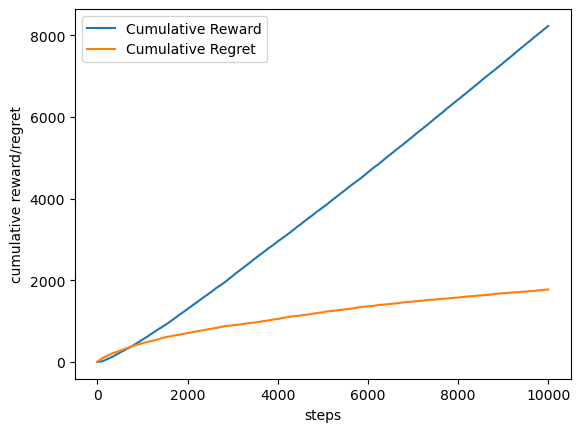

In [7]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward, label='Cumulative Reward')
plt.plot(cumulative_regret, label='Cumulative Regret')
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [8]:
# average reward
print(sum(metrics["reward"][:10]) / 10)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:10]) / 10)
print(sum(metrics["regret"][:1000]) / 1000)
print(sum(metrics["regret"][:10000]) / 10000)

0.2
0.544
0.8226
0.8
0.456
0.1774


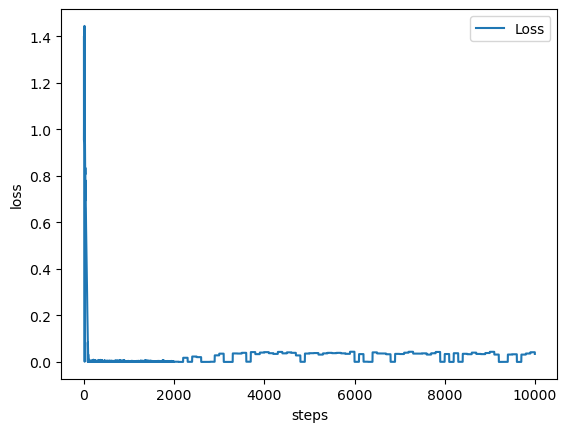

In [9]:
plt.plot(metrics["loss"][:10000], label='Loss')
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()